In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from itertools import combinations

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import json

In [2]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/ensemble_TEST/"
if not os.path.exists(output_path):
    if not os.path.exists("./output"):
        os.mkdir("./output")
    os.mkdir(output_path)

In [3]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-01-01,69.300,70.900,60.600,59.100,67.300,76.000,65.100,77.500,76.000,1.407,...,2.841,14.296,9428739130.435,9561243478.261,6812040180.456,313060869.565,622682608.696,442793757.206,606.622,608.082
1986-02-01,70.300,70.800,61.300,59.100,66.900,77.600,64.200,78.100,68.400,1.405,...,-4.478,9.559,9165285714.286,9106676190.476,6502263046.461,383390476.190,512947619.048,366073168.743,606.279,611.963
1986-03-01,70.600,71.100,61.300,59.300,67.000,79.200,64.200,78.600,66.200,1.402,...,0.319,6.030,9538315909.091,9025059090.909,6472680745.906,643281818.182,787818181.818,564397250.822,610.411,616.374
1986-04-01,71.300,71.000,61.400,59.700,67.700,82.200,63.600,79.500,71.100,1.388,...,4.949,8.596,9987768181.818,9340663636.364,6757418824.383,516097727.273,672050000.000,486285431.349,617.969,622.599
1986-05-01,71.200,71.400,61.900,59.900,68.200,83.500,64.000,79.800,75.300,1.376,...,-2.012,4.617,9644463636.364,9151795454.545,6618074201.845,651663636.364,613938636.364,444258854.381,624.767,627.842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,157.700,145.300,146.200,163.900,156.800,144.500,176.700,142.200,153.400,1.222,...,0.381,25.366,51335625000.000,50870059090.909,41139550592.277,2094113636.364,2165031818.182,1761199406.222,4267.526,4315.057
2021-07-01,157.900,146.400,146.600,165.200,157.600,141.700,180.900,141.900,154.800,1.252,...,-0.063,16.739,51718818181.818,51617813636.364,41104803027.469,818284090.909,1866495454.545,1484497752.632,4295.341,4330.297
2021-08-01,158.500,148.300,146.800,165.900,158.000,142.500,182.100,141.700,152.200,1.259,...,-2.861,11.774,51656260869.565,50431956521.739,39930427974.475,1424895652.174,2484221739.130,1967285267.303,4330.822,4351.796
2021-09-01,158.100,148.000,147.100,165.900,158.500,141.500,184.800,144.300,150.000,1.267,...,-3.461,8.557,50795600000.000,49653000000.000,39197298732.615,1560600000.000,2277300000.000,1797756598.872,4346.662,4367.402


In [4]:
all_experiment_names = pd.Series(list(os.walk("./output"))[0][1])
all_experiment_names = all_experiment_names[~all_experiment_names.str.contains('ensemble')]
all_experiment_names

0            nbeats_TEST
1    nbeatsfredvars_TEST
3           prophet_TEST
dtype: object

In [5]:
experiment_names = all_experiment_names.copy()
report_sim_dates = pd.read_csv("./reportsimdates.txt", sep='\n', header=None)[0].to_list()
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

In [7]:
ex_name = "prophet_TEST"
sim_date = "2017-07-01"
fc = pd.read_csv(f"./output/{ex_name}/forecasts_{sim_date}.csv", index_col=0)
fc.index = pd.DatetimeIndex(fc.index)
fc

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
2017-08-01,156.038,136.235,135.402,145.575,145.293,140.011,164.653,135.539,131.874
2017-09-01,155.385,136.211,135.273,145.737,144.686,137.649,165.068,135.237,125.760
2017-10-01,156.271,135.881,135.171,146.007,144.765,137.003,164.940,135.068,126.328
2017-11-01,156.302,136.085,135.456,146.253,145.501,137.477,165.471,135.064,133.239
2017-12-01,156.807,135.949,135.223,146.482,145.770,137.725,165.629,134.267,136.046
2018-01-01,156.353,136.230,136.442,146.945,146.634,138.525,166.202,135.836,140.330
2018-02-01,156.889,136.722,136.938,147.198,147.041,138.222,166.866,136.243,141.608
2018-03-01,156.804,136.707,137.166,147.336,147.128,137.956,167.366,136.488,141.254
2018-04-01,157.343,136.565,137.251,147.547,147.284,138.280,167.753,136.434,140.907
2018-05-01,157.024,136.642,138.197,147.796,147.730,141.125,168.545,136.219,141.512


In [8]:
def get_forecast_df(food_category, experiment_names, experiment_date):

    forecasts = []

    for ex_name in experiment_names:
        fc_df = pd.read_csv(f"./output/{ex_name}/forecasts_{experiment_date}.csv")
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        else:
            fc_df = fc_df.set_index("Unnamed: 0")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(ex_name)
        forecasts.append(fc_series)

    return pd.concat(forecasts, axis=1)

In [9]:
get_forecast_df("Meat", experiment_names, "2017-07-01")

,nbeats_TEST,nbeatsfredvars_TEST,prophet_TEST
Unnamed: 0,,,
2017-08-01,158.808,157.416,164.653
2017-09-01,162.684,158.423,165.068
2017-10-01,158.463,156.547,164.940
2017-11-01,163.063,157.137,165.471
2017-12-01,164.100,157.242,165.629
2018-01-01,160.104,157.259,166.202
2018-02-01,157.517,157.847,166.866
2018-03-01,160.728,157.627,167.366
2018-04-01,164.529,158.548,167.753


In [10]:
def eval_mean_forecast(foodprice_df, food_category, experiment_date, valid_dates):
      
    valid_series = foodprice_df.loc[valid_dates][food_category]                                 # Select the validation data. 
    all_forecasts = get_forecast_df(food_category, experiment_names, experiment_date)       # Produce the validation period forecast.
    mean_forecast = all_forecasts.mean(axis=1)
    std_forecast =  all_forecasts.std(axis=1)

    valid_metrics = {metric_name: metric_fn(y_true=valid_series,                        # Compute validation metrics. 
                                      y_pred=mean_forecast) for metric_name, metric_fn in metrics.items()}

    return valid_series, mean_forecast, std_forecast, valid_metrics

## Ensemble and evaluate forecasts

In [11]:
all_valid_metrics = {}
all_forecasts = {}

for report_sim_date in report_sim_dates:

    food_forecasts = {}
    food_scores = {}

    for category in food_categories:
        actual, fc, fc_std, scores = eval_mean_forecast(foodprice_df, category, date, sim_valid_dates[date])
        food_scores[category] = scores
        food_forecasts[category] = fc
        
    all_valid_metrics[report_sim_date] = food_scores
    all_forecasts[report_sim_date] = food_forecasts

In [12]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
# mean_scores.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_scores

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-1.972,1.638,0.010,5.394,2.322
Dairy products and eggs,-3.926,5.144,0.035,34.083,5.838
"Fish, seafood and other marine products",-1.970,2.299,0.016,8.359,2.891
Food purchased from restaurants,-2.330,3.094,0.019,12.134,3.483
Food,-1.007,2.290,0.015,7.795,2.792
"Fruit, fruit preparations and nuts",-0.263,1.557,0.011,3.365,1.834
Meat,-0.201,4.409,0.024,41.636,6.453
Other food products and non-alcoholic beverages,-0.242,2.398,0.017,8.526,2.920
Vegetables and vegetable preparations,-0.655,4.431,0.029,27.373,5.232


## Visualize All Forecasts

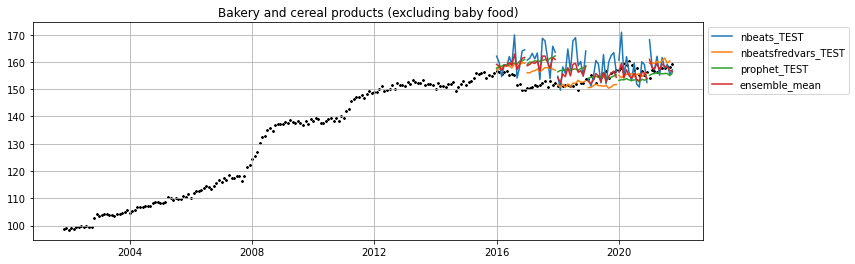

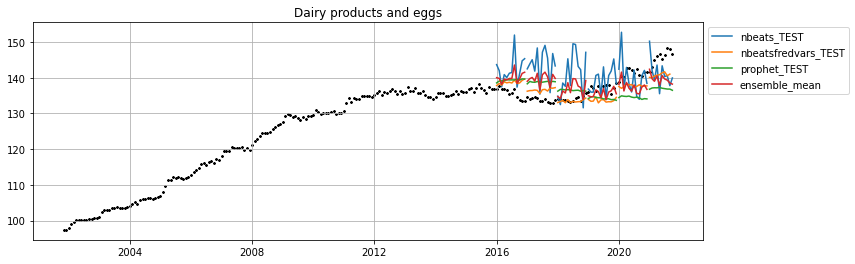

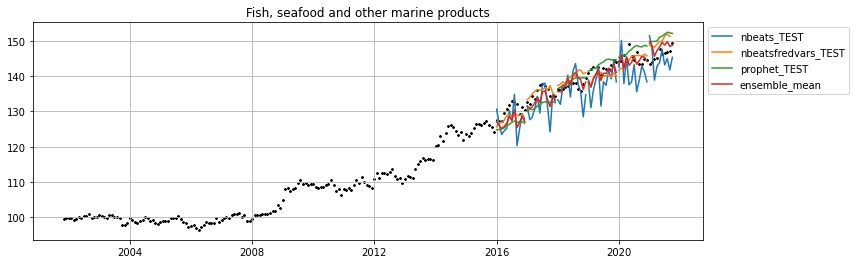

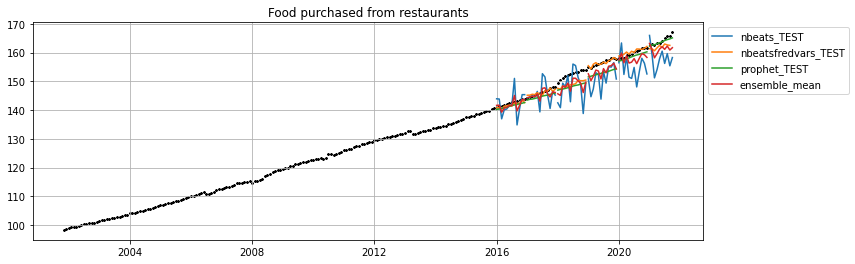

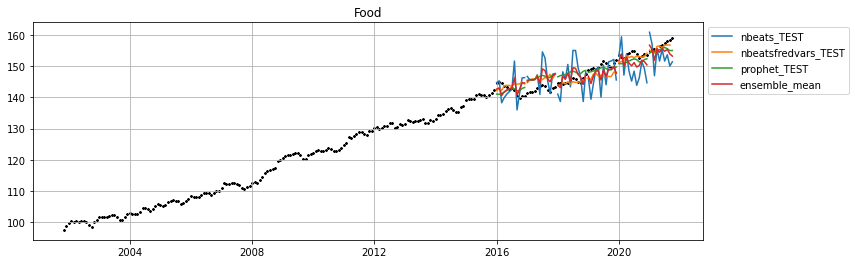

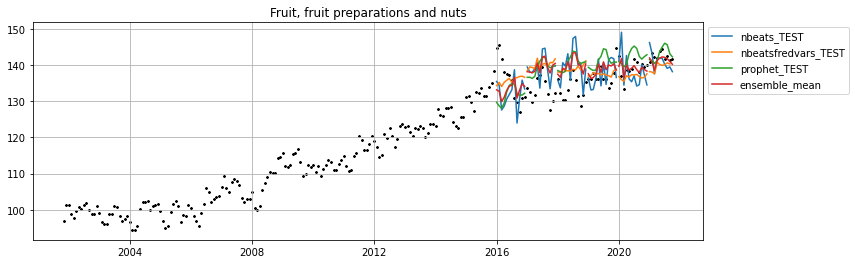

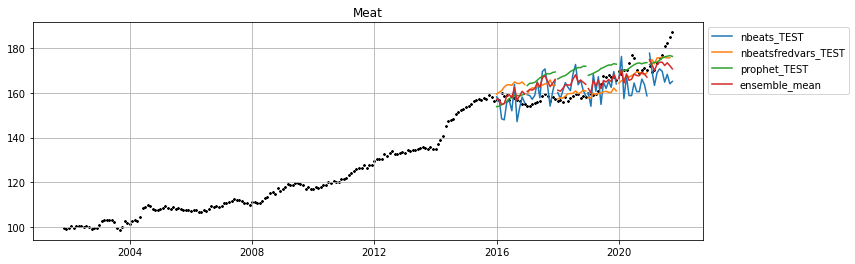

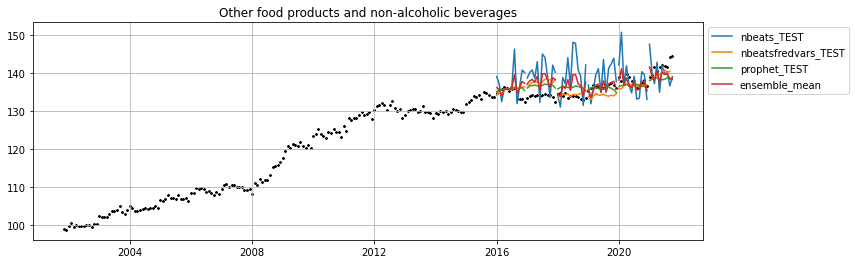

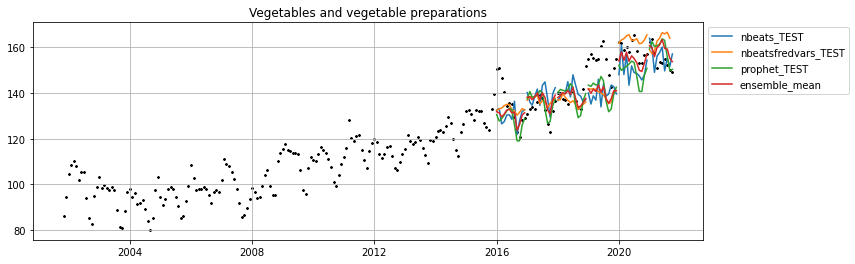

In [13]:
food_col_stats = {}

for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    date_stats = []

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, experiment_names, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]
        all_forecasts = all_forecasts.assign(ensemble_mean=all_forecasts.mean(axis=1))

        ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1)

        col_stats = {}

        for index, col in enumerate(all_forecasts):

            # Collect some stats
            y_pred = all_forecasts[col]
            y_true = foodprice_df[category].loc[y_pred.index]
            col_stats[col] = y_pred - y_true

            if d_index < 1:
                ax.plot(all_forecasts[col], color=f"C{index}", label=col)
            else:
                ax.plot(all_forecasts[col], color=f"C{index}")

        date_stats.append(pd.DataFrame(col_stats))
    
    food_col_stats[category] = pd.concat(date_stats, axis=0)

    plt.title(category)
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_raw_{category}.svg", bbox_inches='tight')
    plt.show()


In [14]:
from scipy.stats import ttest_1samp

all_t_stats = []

for col in food_col_stats:
    for exp_col in food_col_stats[col]:

        errors = food_col_stats[col][exp_col].dropna(axis=0).values
        t_stat, p_value = ttest_1samp(errors, popmean=0)
        # print(col, exp_col, t_stat, p_value)
        all_t_stats.append({"Category": col, "Experiment": exp_col, 't_statistic': t_stat, 'p_value': p_value})

In [15]:
pd.DataFrame(all_t_stats)

,Category,Experiment,t_statistic,p_value
0,Bakery and cereal products (excluding baby food),nbeats_TEST,6.468,0.000
1,Bakery and cereal products (excluding baby food),nbeatsfredvars_TEST,2.241,0.028
2,Bakery and cereal products (excluding baby food),prophet_TEST,3.893,0.000
3,Bakery and cereal products (excluding baby food),ensemble_mean,5.155,0.000
4,Dairy products and eggs,nbeats_TEST,4.219,0.000
5,Dairy products and eggs,nbeatsfredvars_TEST,-2.424,0.018
6,Dairy products and eggs,prophet_TEST,-1.594,0.116
7,Dairy products and eggs,ensemble_mean,0.787,0.434
8,"Fish, seafood and other marine products",nbeats_TEST,-5.860,0.000
9,"Fish, seafood and other marine products",nbeatsfredvars_TEST,0.429,0.670


## Visualize Mean Forecasts

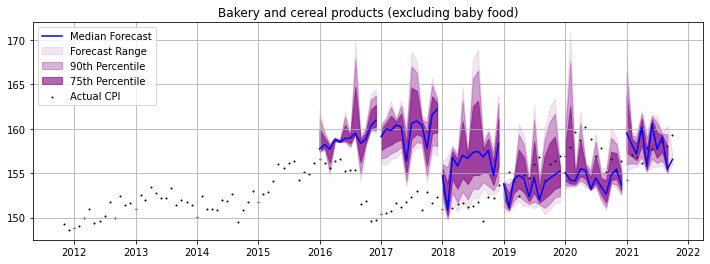

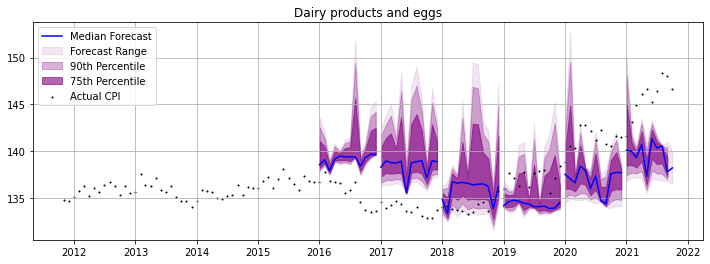

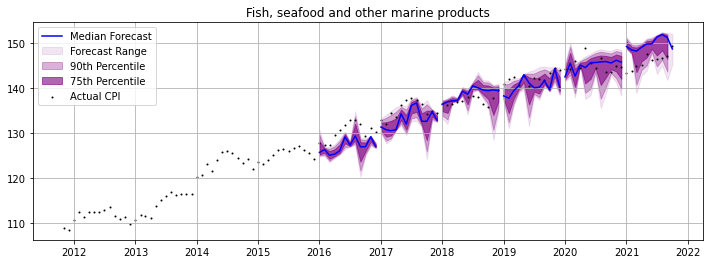

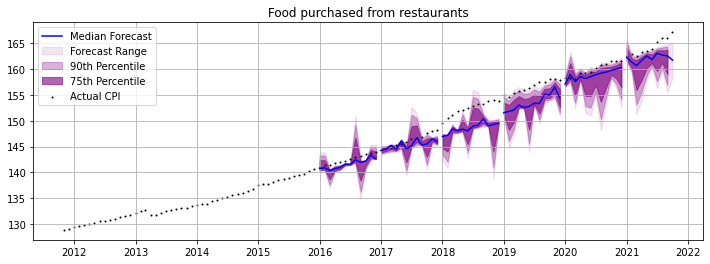

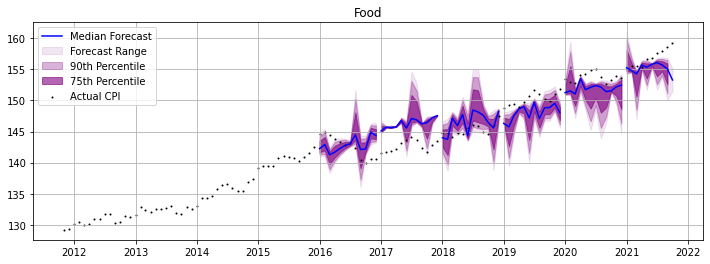

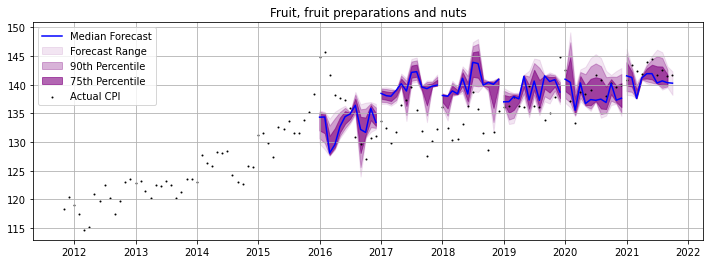

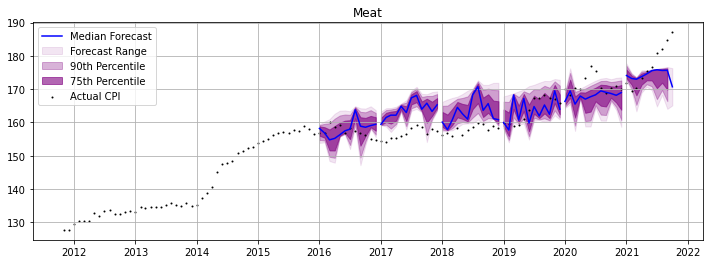

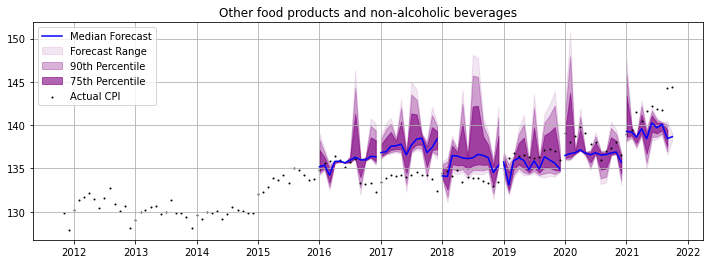

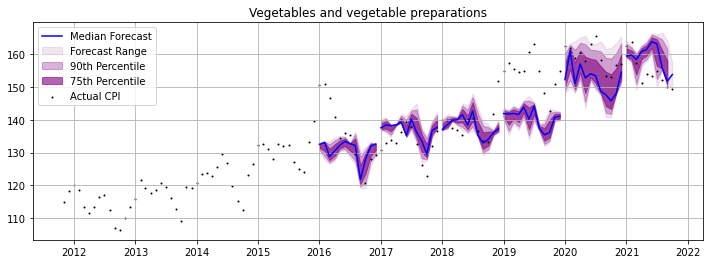

In [16]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, experiment_names, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

        forecast_min = np.min(all_forecasts, axis=1) 
        forecast_10 = np.percentile(all_forecasts, 10, axis=1)
        forecast_25 = np.percentile(all_forecasts, 25, axis=1)
        forecast_75 = np.percentile(all_forecasts, 75, axis=1)
        forecast_90 = np.percentile(all_forecasts, 90, axis=1)
        forecast_max = np.max(all_forecasts, axis=1) 

        if d_index < 1:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red', label='Mean Forecast')
            ax.plot(all_forecasts.index, all_forecasts.median(axis=1), color='blue', label='Median Forecast')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple', label='Forecast Range')
            ax.fill_between(all_forecasts.index, forecast_10, forecast_90, alpha=0.3, color='purple', label='90th Percentile')
            ax.fill_between(all_forecasts.index, forecast_25, forecast_75, alpha=0.6, color='purple', label='75th Percentile')
        else:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red')
            ax.plot(all_forecasts.index, all_forecasts.median(axis=1), color='blue')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple')
            ax.fill_between(all_forecasts.index, forecast_10, forecast_90, alpha=0.3, color='purple')
            ax.fill_between(all_forecasts.index, forecast_25, forecast_75, alpha=0.6, color='purple')

    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1, label="Actual CPI")
    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_range_{category}.svg", bbox_inches='tight')
    plt.show()


## Search for the best-validating ensembles per-category over the whole validation period

With the multivariate NeuralProphet models, there are now many model configurations to choose from. Which ones should be combined and ensembled? Let's do this in a completely systematic way and find the configuration that validates best. We'll do this separately for each food price category.

In [17]:
all_combinations = []

for c_size in range(1, 4):
    for exp in combinations(experiment_names, c_size):
        all_combinations.append(exp)

print(len(all_combinations))

7


In [18]:
category_config_scores = {}

for category in food_categories:

    print(f"Computing ensemble scores for {category}")

    config_scores = {}
    config_stddevs = {}

    for config_index, exp_config in enumerate(all_combinations):

        if config_index % 100 == 0:
            print(f"Processing config {config_index + 1} of {len(all_combinations)}...")

        valid_date_errors = []

        for d_index, date in enumerate(report_sim_dates):

            all_forecasts = get_forecast_df(category, exp_config, date)

            all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
            all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

            mean_forecast = all_forecasts.mean(axis=1)
            actual_cpi = foodprice_df[category][mean_forecast.index]

            analysis_df = pd.DataFrame({'y': actual_cpi, 'yhat': mean_forecast})
            valid_date_errors.append(mean_absolute_percentage_error(y_true=analysis_df.y, y_pred=analysis_df.yhat))

        mean_mape = np.mean(valid_date_errors)
        std_mape = np.std(valid_date_errors)
        config_scores[str(exp_config)] = mean_mape
        config_stddevs[str(exp_config)] = std_mape
        
    category_config_scores[category] =  pd.DataFrame({'mape': config_scores, 'stddev': config_stddevs})  # pd.Series(config_scores, name='mape').to_frame()

Computing ensemble scores for Bakery and cereal products (excluding baby food)
Processing config 1 of 7...
Computing ensemble scores for Dairy products and eggs
Processing config 1 of 7...
Computing ensemble scores for Fish, seafood and other marine products
Processing config 1 of 7...
Computing ensemble scores for Food purchased from restaurants
Processing config 1 of 7...
Computing ensemble scores for Food
Processing config 1 of 7...
Computing ensemble scores for Fruit, fruit preparations and nuts
Processing config 1 of 7...
Computing ensemble scores for Meat
Processing config 1 of 7...
Computing ensemble scores for Other food products and non-alcoholic beverages
Processing config 1 of 7...
Computing ensemble scores for Vegetables and vegetable preparations
Processing config 1 of 7...


<AxesSubplot:ylabel='Frequency'>

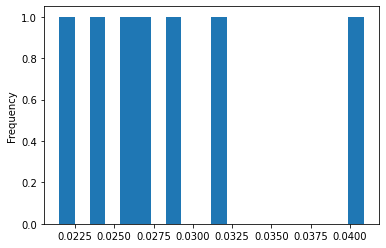

In [20]:
category_config_scores['Bakery and cereal products (excluding baby food)'].mape.plot(kind='hist', bins=20)

In [21]:
# for category in food_categories:
#     ensemble_results = category_config_scores[category].sort_values('mape')
#     ensemble_results.to_csv(f"./report_output/ensemble_scores_{category}.csv")

In [22]:
category_config_scores["Meat"].head(60)

,mape,stddev
"('nbeats_TEST',)",0.039,0.012
"('nbeatsfredvars_TEST',)",0.026,0.010
"('prophet_TEST',)",0.039,0.023
"('nbeats_TEST', 'nbeatsfredvars_TEST')",0.030,0.008
"('nbeats_TEST', 'prophet_TEST')",0.034,0.013
"('nbeatsfredvars_TEST', 'prophet_TEST')",0.028,0.014
"('nbeats_TEST', 'nbeatsfredvars_TEST', 'prophet_TEST')",0.029,0.011


In [23]:
category_config_scores["Vegetables and vegetable preparations"].sort_values('mape')

,mape,stddev
"('nbeatsfredvars_TEST', 'prophet_TEST')",0.041,0.024
"('nbeats_TEST', 'nbeatsfredvars_TEST', 'prophet_TEST')",0.044,0.022
"('prophet_TEST',)",0.047,0.021
"('nbeats_TEST', 'nbeatsfredvars_TEST')",0.047,0.023
"('nbeats_TEST', 'prophet_TEST')",0.048,0.022
"('nbeatsfredvars_TEST',)",0.050,0.023
"('nbeats_TEST',)",0.055,0.020


In [24]:
results = {}
for category in food_categories:
    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    if '' in best_exp_config:
        best_exp_config.remove('')
    results[category] = best_exp_config
    print(f"{category}\t{best_exp_config}\t{category_config_scores[category]['mape'].min()}\t{category_config_scores[category].sort_values('mape')['stddev'][0]}")

Bakery and cereal products (excluding baby food)	['nbeatsfredvars_TEST']	0.021505438742303536	0.009662170350430923
Dairy products and eggs	['nbeatsfredvars_TEST']	0.022004544520817824	0.008477670834583832
Fish, seafood and other marine products	['nbeats_TEST', 'nbeatsfredvars_TEST', 'prophet_TEST']	0.01600292919776469	0.0040383938692484765
Food purchased from restaurants	['nbeatsfredvars_TEST']	0.008351586437826805	0.006947416489330071
Food	['nbeatsfredvars_TEST', 'prophet_TEST']	0.01323843402776101	0.006099236011446684
Fruit, fruit preparations and nuts	['nbeatsfredvars_TEST', 'prophet_TEST']	0.03049964855271753	0.01686631274097007
Meat	['nbeatsfredvars_TEST']	0.025768319768162795	0.010101973250670332
Other food products and non-alcoholic beverages	['nbeatsfredvars_TEST', 'prophet_TEST']	0.013864881616343498	0.005458823648782551
Vegetables and vegetable preparations	['nbeatsfredvars_TEST', 'prophet_TEST']	0.04127384269753029	0.023635482457982644


In [25]:
results

{'Bakery and cereal products (excluding baby food)': ['nbeatsfredvars_TEST'],
 'Dairy products and eggs': ['nbeatsfredvars_TEST'],
 'Fish, seafood and other marine products': ['nbeats_TEST',
  'nbeatsfredvars_TEST',
  'prophet_TEST'],
 'Food purchased from restaurants': ['nbeatsfredvars_TEST'],
 'Food': ['nbeatsfredvars_TEST', 'prophet_TEST'],
 'Fruit, fruit preparations and nuts': ['nbeatsfredvars_TEST', 'prophet_TEST'],
 'Meat': ['nbeatsfredvars_TEST'],
 'Other food products and non-alcoholic beverages': ['nbeatsfredvars_TEST',
  'prophet_TEST'],
 'Vegetables and vegetable preparations': ['nbeatsfredvars_TEST',
  'prophet_TEST']}

In [26]:
scores = {}
for food_category in food_categories:
    best_index = category_config_scores[food_category].mape.idxmin()
    scores[food_category] = category_config_scores[food_category].loc[best_index]

In [27]:
"""
The following scores provide uncertainty ranges for best ensemble
mean forecasts over the simulated report years. For example, if for
Meat we observe a mape of 0.026 and stddev of 0.010, we could say
that over the last 6 years, this methodology's forecasts had an average
error of 2.6% +/- 1.0% standard deviation. Our experiments are designed
to select the category-specific model ensemble that would have had the 
lowest MAPE, on average, if the ensemble had been used over the last 6 years.
"""

results_df = pd.DataFrame(scores).T
results_df["best_config"] = pd.Series(results, name='best_config')
results_df

,mape,stddev,best_config
Bakery and cereal products (excluding baby food),0.022,0.010,[nbeatsfredvars_TEST]
Dairy products and eggs,0.022,0.008,[nbeatsfredvars_TEST]
"Fish, seafood and other marine products",0.016,0.004,"[nbeats_TEST, nbeatsfredvars_TEST, prophet_TEST]"
Food purchased from restaurants,0.008,0.007,[nbeatsfredvars_TEST]
Food,0.013,0.006,"[nbeatsfredvars_TEST, prophet_TEST]"
"Fruit, fruit preparations and nuts",0.030,0.017,"[nbeatsfredvars_TEST, prophet_TEST]"
Meat,0.026,0.010,[nbeatsfredvars_TEST]
Other food products and non-alcoholic beverages,0.014,0.005,"[nbeatsfredvars_TEST, prophet_TEST]"
Vegetables and vegetable preparations,0.041,0.024,"[nbeatsfredvars_TEST, prophet_TEST]"


## Save the ensemble configurations to file

In [28]:
"""
Save ensemble configurations and scores. 
"""
results_df.to_pickle(f"{output_path}/ensemble_results.pkl")

## Visualize the best ensemble forecasts per category and collect the best configuration MAPEs

Bakery and cereal products (excluding baby food)
['nbeatsfredvars_TEST']



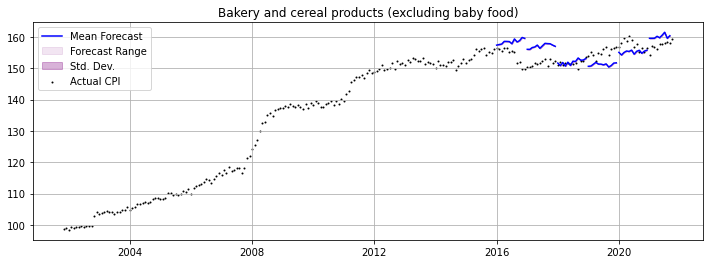

Dairy products and eggs
['nbeatsfredvars_TEST']



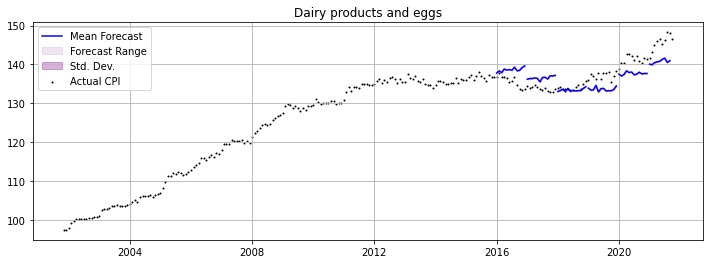

Fish, seafood and other marine products
['nbeats_TEST', 'nbeatsfredvars_TEST', 'prophet_TEST']



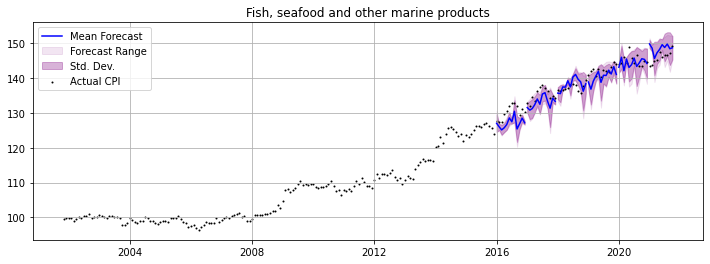

Food purchased from restaurants
['nbeatsfredvars_TEST']



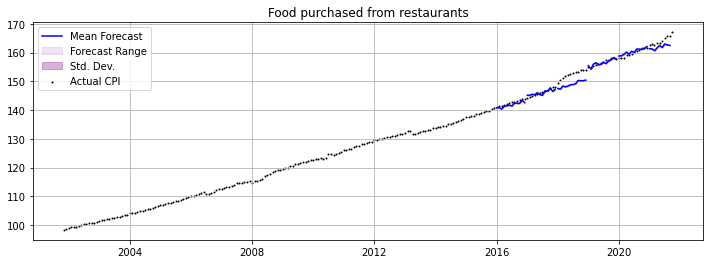

Food
['nbeatsfredvars_TEST', 'prophet_TEST']



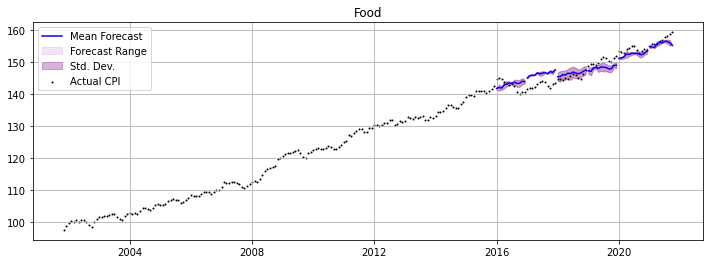

Fruit, fruit preparations and nuts
['nbeatsfredvars_TEST', 'prophet_TEST']



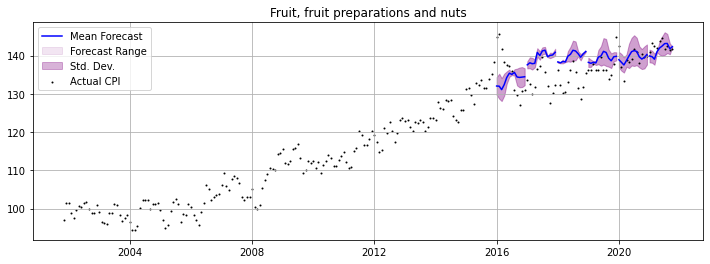

Meat
['nbeatsfredvars_TEST']



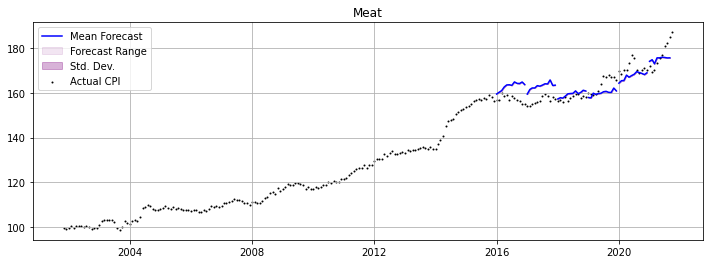

Other food products and non-alcoholic beverages
['nbeatsfredvars_TEST', 'prophet_TEST']



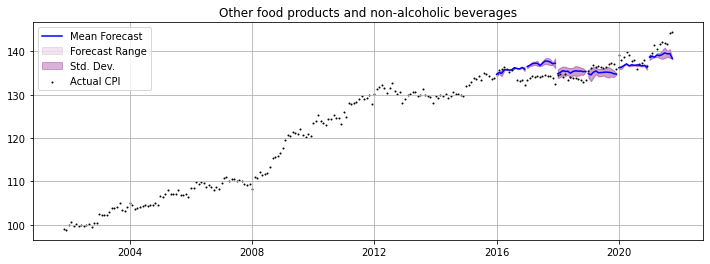

Vegetables and vegetable preparations
['nbeatsfredvars_TEST', 'prophet_TEST']



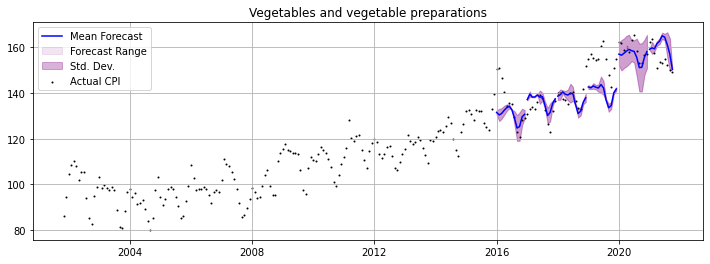

In [29]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    best_exp_config = [config for config in best_exp_config if len(config) > 0]

    print(category)
    print(best_exp_config)
    print()

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, best_exp_config, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

        forecast_min = np.min(all_forecasts, axis=1) 
        forecast_std = np.std(all_forecasts, axis=1)
        forecast_mean = np.mean(all_forecasts, axis=1)
        forecast_max = np.max(all_forecasts, axis=1) 

        if d_index < 1:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red', label='Mean Forecast')
            ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='blue', label='Mean Forecast')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple', label='Forecast Range')
            ax.fill_between(all_forecasts.index, forecast_mean - forecast_std, forecast_mean + forecast_std, alpha=0.3, color='purple', label='Std. Dev.')
        else:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red')
            ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='blue')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple')
            ax.fill_between(all_forecasts.index,forecast_mean - forecast_std, forecast_mean + forecast_std, alpha=0.3, color='purple')

    ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1, label="Actual CPI")
    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_range_{category}.svg", bbox_inches='tight')
    plt.show()


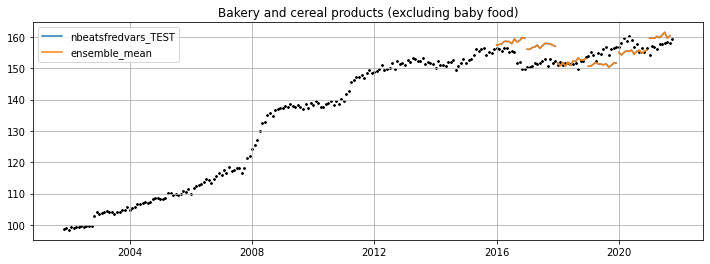

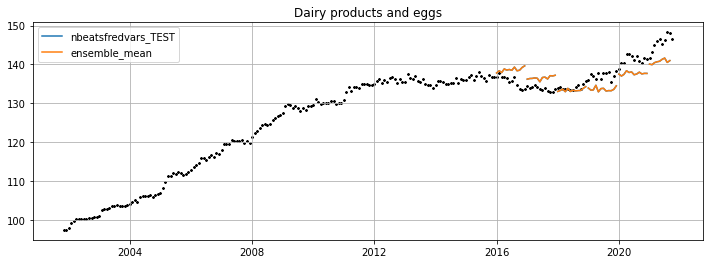

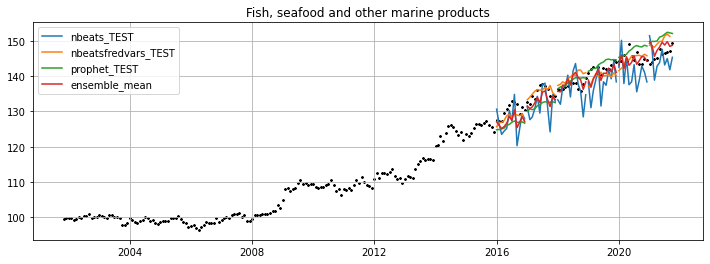

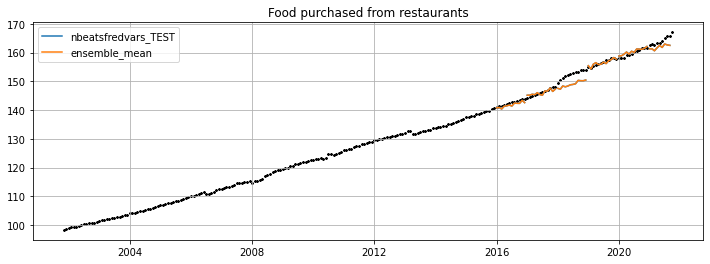

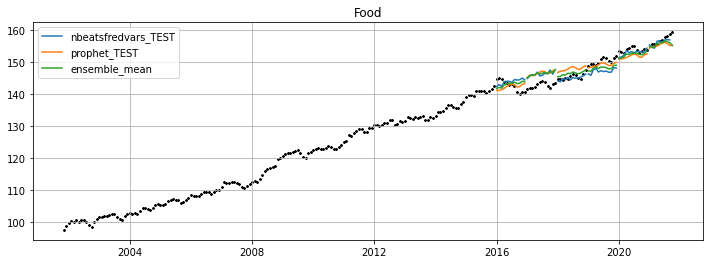

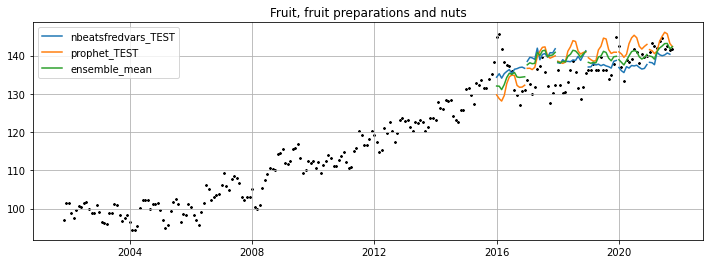

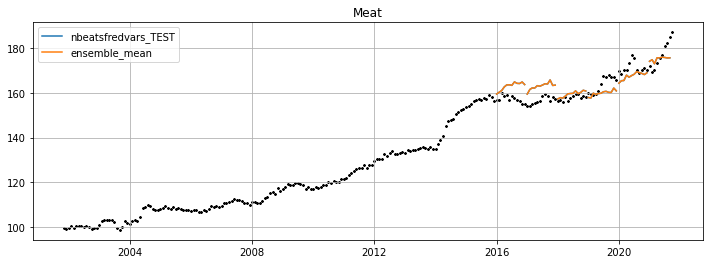

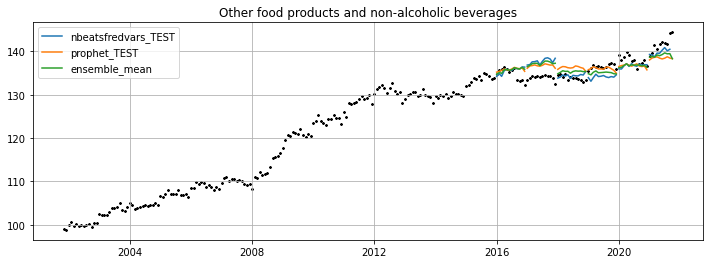

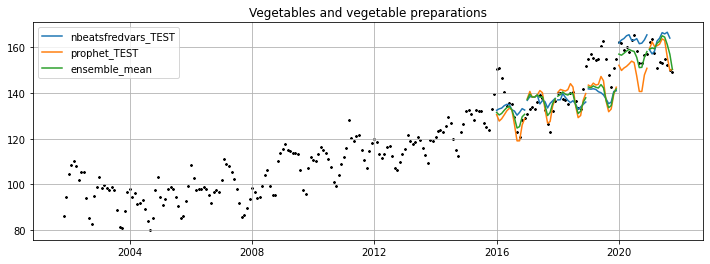

In [30]:
food_col_stats = {}

for category in food_categories:

    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    best_exp_config = [config for config in best_exp_config if len(config) > 0]

    fig, ax = plt.subplots(figsize=(12,4))
    date_stats = []

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, best_exp_config, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]
        all_forecasts = all_forecasts.assign(ensemble_mean=all_forecasts.mean(axis=1))

        ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1)

        col_stats = {}

        for index, col in enumerate(all_forecasts):

            # Collect some stats
            y_pred = all_forecasts[col]
            y_true = foodprice_df[category].loc[y_pred.index]
            col_stats[col] = y_pred - y_true

            if d_index < 1:
                ax.plot(all_forecasts[col], color=f"C{index}", label=col)
            else:
                ax.plot(all_forecasts[col], color=f"C{index}")

        date_stats.append(pd.DataFrame(col_stats))
    
    food_col_stats[category] = pd.concat(date_stats, axis=0)

    plt.title(category)
    plt.legend(loc='best')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_raw_{category}.svg", bbox_inches='tight')
    plt.show()
